# Webscraper for https://www.hemnet.se

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [4]:
def get_nbr_pages(url):
    result = requests.get(url)
    src = result.content
    soup = BeautifulSoup(src)
    return int([a_tag.contents[0] for a_tag in soup.find_all('a', class_="button")][-2])

In [5]:
def get_next_url(url):
    result = requests.get(url)
    src = result.content
    soup = BeautifulSoup(src)
    next_url = soup.find('a', class_="next_page button button--primary")
    if next_url is not None:
        next_url = 'https://hemnet.se/' + next_url.attrs['href']
    return next_url

In [6]:
def get_columns(url):
    
    result = requests.get(url)
    src = result.content
    soup = BeautifulSoup(src)

    columns = []
    for a in soup.find_all('dt', text=lambda s: s != "Prisutveckling"):
        columns.append(a.contents[0])
    columns.append('Slutpris')
    columns.insert(0, 'Datum')
    columns.insert(1, 'Område')
    return columns

In [9]:
def scrape(urls):
    
    all_values = []
    for url in urls:
        values = []
        result = requests.get(url)
        src = result.content
        soup = BeautifulSoup(src)
        for a in soup.find_all('dd'):
            value = a.contents[0].strip(' kr').strip(' kr/m²').strip(' rum')\
                                 .strip(' kr/mån').strip(' kr/å').strip('\n').replace(u"\xa0", "").replace(',', '.')

            if 'Brf' not in value and value != '':
                values.append(value)
                
        # Gets the closing price 
        closing_price = soup.find_all('span', class_="sold-property__price-value")
        closing_price = closing_price[0].contents[0].strip(' kr').replace(u"\xa0", "")
        values.append(closing_price)
                
        # Gets the time of sale
        time = soup.find('time').contents[0].strip('\n').strip('\n    ')
        values.insert(0, time)
        
        # Gets the location of object
        area = soup.find("p").find("span") \
            .next_sibling \
            .strip("Stockholms kommun\n\n    - Såld den\n    ") \
            .strip("Bostadsrättslägenhet - \n\n") \
            .strip("Andel i bostadsförening -\n\n") \
            .strip(',')
        values.insert(1, area)
        
        all_values.append(values)
        
    return all_values

In [11]:
def get_search_urls(url):
    result = requests.get(url)
    src = result.content
    soup = BeautifulSoup(src)

    urls = []
    for li_tag in soup.find_all('li'):
        for div_tag in li_tag.find_all('div'):
            a_tag = div_tag.find('a')
            if a_tag != None:
                urls.append(a_tag.attrs['href'])

    urls = [x for x in urls if x.startswith("https://www.hemnet.se/")]
    return urls

In [41]:
search = 'https://www.hemnet.se/salda/bostader?item_types%5B%5D=bostadsratt&location_ids%5B%5D=473362&location_ids%5B%5D=898472&location_ids%5B%5D=473448&location_ids%5B%5D=925970&location_ids%5B%5D=925969&location_ids%5B%5D=925968&page=1&sold_age=all'

columns = [
        'Datum',
        'Område',
        'Pris per kvadratmeter',
        'Begärt pris',
        'Antal rum',
        'Boarea',
        'Avgift/månad',
        'Driftskostnad',
        'Byggår',
        'Slutpris'
        ]

In [42]:
current_search_page = search
i = 0
first = True
while get_next_url(current_search_page) is not None:
    
    if i > 10:
        break
    
    current_search_page = get_next_url(current_search_page)
    
    urls = get_search_urls(current_search_page)
    
    print("Scraping page", i)
    temp = scrape(urls)
    temp = pd.DataFrame(temp)
    
    if first != False:
        df = temp
        first = False
    
    df = pd.concat([df, temp])
    i += 1
    

Scraping page 0
Scraping page 1
Scraping page 2
Scraping page 3
Scraping page 4
Scraping page 5
Scraping page 6
Scraping page 7
Scraping page 8
Scraping page 9
Scraping page 10


In [46]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,12 oktober 2019,Kungsholmen,91974,3195000,1.5,38,1223,6100,1927,3495000,NaN
1,11 oktober 2019,Maria,80714,5450000,2,70,3979,1907,5650000,None,NaN
2,11 oktober 2019,Katarina,90625,3995000,2,48,1456,4350000,None,None,NaN
3,11 oktober 2019,Vasastan,88655,9495000,5,119,5134,1926,10550000,None,NaN
4,11 oktober 2019,Vasastan,87179,6295000,3,78,3108,5000,1979,6800000,NaN


In [47]:
df = df.drop(10, axis=1)

In [48]:
df.columns = columns

### Post-processing

In [50]:
temp = df.loc[df.Slutpris.isna()]
temp.loc[:, 'Slutpris'] = temp['Byggår'].values
temp.loc[:, 'Byggår'] = temp['Driftskostnad'].values
temp.loc[:, 'Driftskostnad'] = '0'

temp2 = df.loc[~df.Slutpris.isna()]

data = pd.concat([temp, temp2])

data = data[~data.Slutpris.isna()].reset_index(drop=True)
#data = data[data['Begärt pris'] ]

# removes buildings without starting price
data = data.loc[data['Begärt pris'].astype(float) > 10000]

data.loc[:,'Byggår'] = data['Byggår'].map(lambda x: x[:4]).values
data = data[data['Avgift/månad'] != '    ']

to_float = ['Antal rum', 'Boarea']
to_int = ['Pris per kvadratmeter', 'Begärt pris', 'Driftskostnad', 'Avgift/månad', 'Byggår', 'Slutpris']

In [51]:
data[to_float] = data[to_float].astype(float)
#data[to_int] = data[to_int].astype(int)
#return data

In [52]:
data.loc[:,'Byggår'] = data['Byggår'].map(lambda x: x[:4]).values

In [53]:
for c in to_int:
    data[c] = pd.to_numeric(data[c], errors='coerce')

The noisiest column seems to be Område, så let's clean it up!

In [60]:
data.Område.unique()

array(['Maria', 'Vasastan', 'Vasastan - Birkastan',
       'Kungsholmen/Hornsbergs Strand', 'Södermalm', 'Hornsbergs strand',
       'Kungsholmen', 'Vasastan - Odenplan', 'Östermalm', '',
       'Vasastan - Röda Bergen/Torsplan', 'Kungsholmen/Hornsbergs strand',
       'Andel i bostadsförening -\n\n    Vasastan', 'Atlas Vasastan',
       'Södermalm - Tanto', 'Andel i bostadsförening -\n\n    Östermalm',
       'Kungsholmen, Fredhäll', 'Kungsholmen - Norr Mälarstrand',
       'Kungsholmen Nedre', 'Karlaplan', 'Kungsholmen/Fredhäll',
       'Södermalm / Hornstull', 'Katarina/Sofia',
       'Södermalm - Mariatorget', 'Vasastan - City/Norrmalm',
       'Andel i bostadsförening -\n\n    Kungsholmen',
       'Vasastan - S:t Eriksplan', 'Hornstull',
       'Kungsholmen/Hornsberg Strand', 'Vasastan - Röda Bergen',
       'Kungsholmen / Kungsholmstorg', 'Kungsholmen Thorildsplan',
       'Kungsholmen/City', 'Kungsholmen - Kristinebergs Strand',
       'Södermalm - Högalid', 'Kungsholmen - Rådhu

In [73]:
areas = [
            'Kungsholmen',
            'Vasastan',
            'Östermalm',
            'Södermalm',
            'Gärdet',
            'Norrmalm',
            'Gamla Stan'
        ]

In [74]:
for a in areas:
    data.loc[data.Område.str.contains(a), 'Område'] = a

In [75]:
data.Område.unique()

array(['Maria', 'Vasastan', 'Kungsholmen', 'Södermalm',
       'Hornsbergs strand', 'Östermalm', '', 'Karlaplan',
       'Katarina/Sofia', 'Hornstull', 'Gamla Stan', 'Sofia', 'irkastan',
       'Hornsbergs Strand', 'Högalid', 'Stockholm', 'Norrmalm',
       'Katarina - Rosenlundshöjden', 'Katarina',
       'Andel i bostadsförening -\n\n    Högalid', 'Fredhäll',
       'Mariaberget', 'Kristineberg', 'Mariatorget', 'Röda Bergen',
       'Kunsgholmen', 'Stadshagen', 'Hagastaden', 'Villastan'],
      dtype=object)

In [99]:
area_mapper = {
              'Högalid' : 'Södermalm',
              'Fredhäll' : 'Kungsholmen',
              'Maria' : 'Södermalm',
              'Hornsberg' : 'Kungsholmen',
              'irkastan' : 'Vasastan',
              'Katarina' : 'Södermalm',
              'Villastan' : 'Östermalm',
              'Röda Bergen' : 'Vasastan',
              'Kristineberg' : 'Kungsholmen'
             }

In [121]:
data = data.dropna()

In [124]:
for a in area_mapper.keys():
    data.loc[data.Område.str.contains(a)]['Område'] = area_mapper[a]

In [125]:
data.Område.unique()

array(['Södermalm', 'Vasastan', 'Kungsholmen', 'Östermalm', '',
       'Karlaplan', 'Hornstull', 'Gamla Stan', 'Sofia', 'Stockholm',
       'Norrmalm', 'Kunsgholmen', 'Stadshagen', 'Hagastaden'],
      dtype=object)

In [126]:
month_map = {
        'januari' : '01',
        'februari' : '02',
        'mars' : '03',
        'april': '04',
        'maj' : '05',
        'juni' : '06',
        'juli' : '07',
        'augusti' : '08',
        'september' : '09',
        'oktober' : '10',
        'november' : '11',
        'december' : '12'
    }

In [127]:
data.Datum.apply(lambda x: x[2:-4].strip(' '))

0        oktober
1        oktober
2        oktober
3        oktober
4        oktober
         ...    
574    september
575    september
576    september
577    september
578    september
Name: Datum, Length: 574, dtype: object

In [128]:
month_series = data.Datum.apply(lambda x: x[2:-4].strip(' ')).map(month_map)
day_series = data.Datum.apply(lambda x: '-' + x[:2] + '-')
year_series = data.Datum.apply(lambda x: x[-4:])
data.Datum = month_series+day_series+year_series

c:\users\erik.norlander\py36\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [129]:
data.Datum = pd.to_datetime(data.Datum)

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 574 entries, 0 to 578
Data columns (total 10 columns):
Datum                    574 non-null datetime64[ns]
Område                   574 non-null object
Pris per kvadratmeter    574 non-null int64
Begärt pris              574 non-null int64
Antal rum                574 non-null float64
Boarea                   574 non-null float64
Avgift/månad             574 non-null int64
Driftskostnad            574 non-null int64
Byggår                   574 non-null int64
Slutpris                 574 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(1)
memory usage: 49.3+ KB


In [141]:
data.sort_values('Datum', ascending=False)

,Datum,Område,Pris per kvadratmeter,Begärt pris,Antal rum,Boarea,Avgift/månad,Driftskostnad,Byggår,Slutpris
267,2019-10-12,Kungsholmen,91974,3195000,1.5,38.0,1223,6100,1927,3495000
236,2019-10-12,Kungsholmen,91974,3195000,1.5,38.0,1223,6100,1927,3495000
238,2019-10-11,Kungsholmen,74000,3395000,2.0,47.5,3304,4800,1937,3515000
269,2019-10-11,Kungsholmen,74000,3395000,2.0,47.5,3304,4800,1937,3515000
281,2019-10-11,Östermalm,138889,13900000,4.0,99.0,4131,12000,1929,13750000
...,...,...,...,...,...,...,...,...,...,...
574,2019-09-19,Vasastan,93077,5495000,2.0,65.0,2471,9036,1905,6050000
575,2019-09-19,Östermalm,85333,6350000,3.0,75.0,1935,4800,1959,6400000
576,2019-09-19,Södermalm,92373,4495000,2.0,59.0,3188,5400,1919,5450000
577,2019-09-19,Södermalm,88814,2250000,1.0,29.5,1284,2400,1964,2620000


In [133]:
data.to_csv('bostadsratter_stockholm_2019_okt16.csv')

In [134]:
import matplotlib.pyplot as plt
plt.plot(data.Datum, data.Slutpris)

c:\users\erik.norlander\py36\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [135]:
pris = data['Pris per kvadratmeter']
pris.index = data.Datum

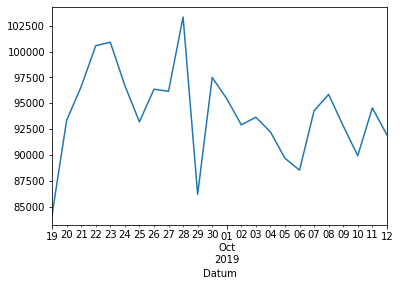

In [138]:
pris.resample('d').mean().plot()

In [992]:
data.Område

0                                      
1       Vasastan - Röda Bergen/Torsplan
2                              Vasastan
3                              ödermalm
4                             Östermalm
                     ...               
4988                          Östermalm
4989                           ödermalm
4990                                fia
4991                              Maria
4992                             Gärdet
Name: Område, Length: 4982, dtype: object

In [139]:
data

,Datum,Område,Pris per kvadratmeter,Begärt pris,Antal rum,Boarea,Avgift/månad,Driftskostnad,Byggår,Slutpris
0,2019-10-11,Södermalm,80714,5450000,2.0,70.0,3979,0,1907,5650000
1,2019-10-11,Vasastan,88655,9495000,5.0,119.0,5134,0,1926,10550000
2,2019-10-11,Vasastan,85246,4995000,2.0,61.0,2415,0,1905,5200000
3,2019-10-11,Kungsholmen,73438,4250000,2.0,64.0,3156,0,2008,4700000
4,2019-10-11,Södermalm,108621,2695000,1.0,29.0,1153,0,1913,3150000
...,...,...,...,...,...,...,...,...,...,...
574,2019-09-19,Vasastan,93077,5495000,2.0,65.0,2471,9036,1905,6050000
575,2019-09-19,Östermalm,85333,6350000,3.0,75.0,1935,4800,1959,6400000
576,2019-09-19,Södermalm,92373,4495000,2.0,59.0,3188,5400,1919,5450000
577,2019-09-19,Södermalm,88814,2250000,1.0,29.5,1284,2400,1964,2620000
